# AdaBoost, detektor twarzy Viola-Jones

## Importy

In [15]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot

## Ładowanie danych

In [3]:
X, y = load_breast_cancer(return_X_y=True)

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=.25, random_state=0)

## AdaBoost

Zobaczmy, jak poradzi sobie AdaBoost z domyślnymi parametrami ze zbiorem Breast Cancer Wisconsin. Dla porównania poniżej jest też zwykłe pojedyncze drzewo decyzyjne.

In [4]:
tree = DecisionTreeClassifier(random_state=0)
tree.fit(train_X, train_y)
print("Tree accuracy:", round(cross_val_score(tree, test_X, test_y, cv=5).mean(), 2))

ada = AdaBoostClassifier(random_state=0)
ada.fit(train_X, train_y)
print("AdaBoost accuracy:", round(cross_val_score(ada, test_X, test_y, cv=5).mean(), 2))

Tree accuracy: 0.92
AdaBoost accuracy: 0.95


Zysk jest całkiem znaczący - 3% dla nieseparowalnych liniowo zbiorów, w okolicy > 90% accuracy, to całkiem nieźle.

### Zadanie 1

Sprawdź, czy faktycznie zgodnie z twierdzeniami wielu osób dla AdaBoosta więcej klasyfikatorów bazowych to zawsze lepiej. Do tego celu sprawdź błąd AdaBoosta za pomocą 5-fold cross validation dla liczby drzew z zakresu 10-200, skacząc co 5, przedstawiając go na wykresie.

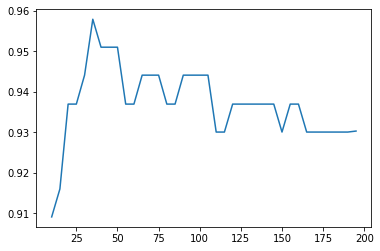

In [5]:
scores, x_axis = [], []

for n in range(10, 200, 5):
    ada = AdaBoostClassifier(n_estimators=n, random_state=0)
    ada.fit(train_X, train_y)
    
    scores.append(cross_val_score(ada, test_X, test_y, cv=5).mean())
    x_axis.append(n)
    
plt.plot(x_axis, scores)
plt.show()

### Zadanie 2

Często w praktyce można mierzyć się z problemem, co jest lepsze - AdaBoost czy RandomForest? Ważne są głównie 3 czynniki: czas treningu, predykcji oraz wyniki w różnych metrykach jakości. Sprawdź dla zbioru Breast Cancer Wisconsin czas treningu, predykcji na zbiorze testowym, accuracy, precision oraz recall dla tych klasyfikatorów. Czy któryś jest wyraźnie lepszy od drugiego w którejkolwiek z tych metryk / we wszystkich z nich?  
Musisz tutaj samodzielnie dokonać importu odpowiednich funkcji - po przerobieniu poprzednich notebooków i z pomocą dokumentacji nie powinno to stanowić problemu.  
Pamiętaj o tym, aby oba klasyfikatory miały taką samą liczbę klasyfikatorów bazowych!

In [6]:
from sklearn.ensemble import RandomForestClassifier
from time import time
from sklearn.metrics import classification_report

In [10]:
def checkFitTime(clf, X, y):
    start = time()
    clf.fit(X, y)
    end = time()
    return end - start

def checkPredTime(clf, X):
    start = time()
    y_pred = clf.predict(X)
    end = time()
    return y_pred, end - start

randForest = RandomForestClassifier(n_estimators=75, random_state=0)
ada = AdaBoostClassifier(n_estimators=75, random_state=0)
clfs = {"RandomForst": randForest, "AdaBoost": ada}
train_X, test_X, train_y, test_y
for name, clf in clfs.items():
    print(f"{name}:")
    print("Fit time: ", checkFitTime(clf, train_X, train_y), ' [s]')
    pred_y, pred_time = checkPredTime(clf, test_X)
    print("Pred time: ", pred_time, ' [s]')
    print()
    print(classification_report(test_y, pred_y))
    print()
    
    # implement things

RandomForst:
Fit time:  0.11595487594604492  [s]
Pred time:  0.0  [s]

              precision    recall  f1-score   support

           0       0.94      0.96      0.95        53
           1       0.98      0.97      0.97        90

    accuracy                           0.97       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.97      0.97      0.97       143


AdaBoost:
Fit time:  0.150252103805542  [s]
Pred time:  0.01813197135925293  [s]

              precision    recall  f1-score   support

           0       0.95      0.98      0.96        53
           1       0.99      0.97      0.98        90

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143




## Detektor twarzy Viola-Jones

Aby używać detektora twarzy Viola-Jones, wykorzystamy najpopularniejszą bibliotekę do computer vision i wszelkiego przetwarzania obrazów, OpenCV, a konkretniej jej Pythonowy interfejs. Na dobry początek załadujemy przykładowe zdjęcie.

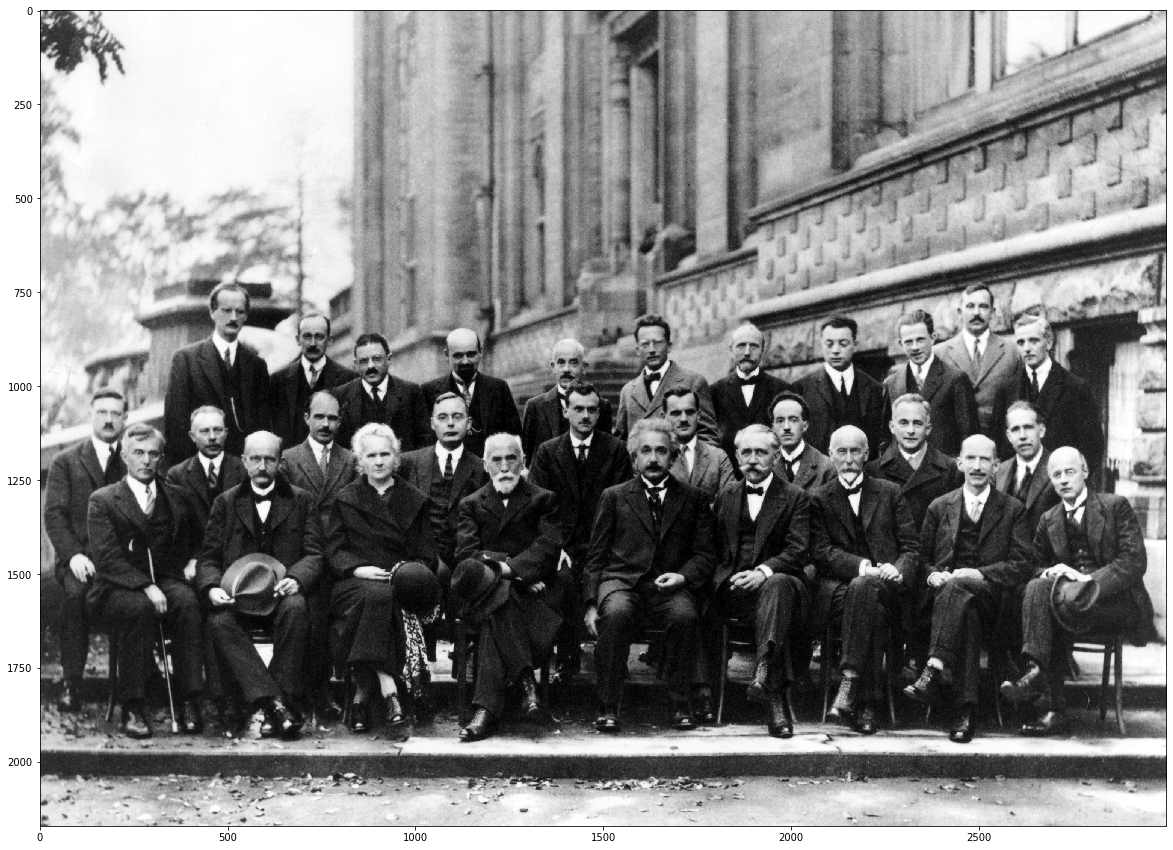

In [33]:
filename = 'solvay.jpg'

img = cv2.imread(filename)
plt.figure(figsize=(25,15))
plt.imshow(img, cmap='gray')

Zauważ, że wskazaliśmy Matplotlibowi szarą skalę kolorów - jest to drobne dziwactwo tej biblioteki, bo skalę szarości domyślnie rysuje w kolorach żółtym i fioletowym, uznając je za lepiej kontrastujące. Jest to oczywiście w praktyce tylko źródło miliona pytań w internecie, czemu tak się dzieje i jak się tego pozbyć.

OpenCV zapewnia gotową wersję detektora Viola-Jones, która wymaga załadowania z pliku architektury klasyfikatorów AdaBoost leżących u jego podstawy, czyli ich liczby, kolejności oraz wag poszczególnych klasyfikatorów bazowych w każdym z nich. Wykorzystywanie takich gotowych modeli w ML jest bardzo częste - nikt nie chciałby w końcu za każdym razem czekać np. kilku minut, godzin czy dni na wytrenowanie złożonych modeli.  
Dostępne modele można znaleźć w https://github.com/opencv/opencv/tree/master/data/haarcascades. Wybrane pliki (do wykrywania twarzy i ciał osób) są na dysku obok tego notebooka.  
Wyjaśnienie poszczególnych argumentów detektora można znaleźć w https://stackoverflow.com/questions/36218385/parameters-of-detectmultiscale-in-opencv-using-python - oficjalna dokumentacja jest w C++ i jej jakość jest zresztą niezbyt wysoka.

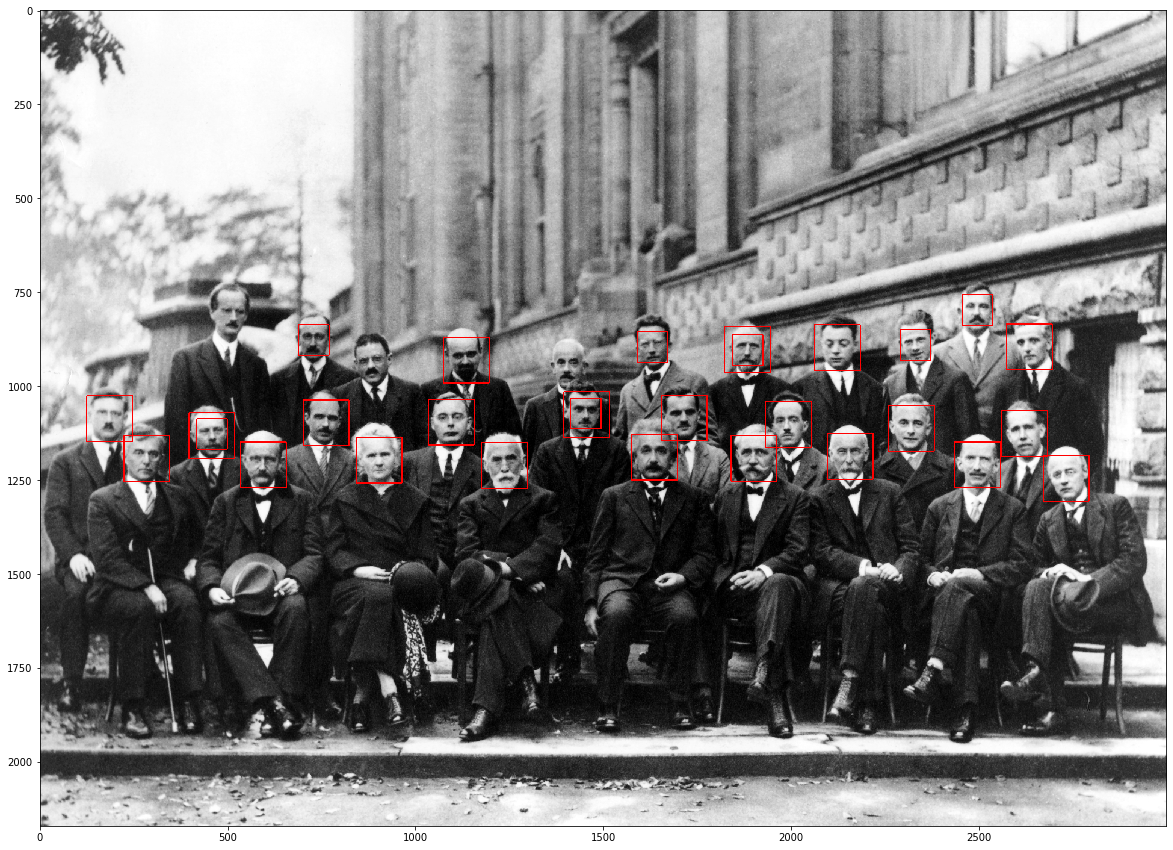

In [34]:
faces_filename = "haarcascade_frontalface_default.xml"

face_cascade = cv2.CascadeClassifier(faces_filename)  # load face detector from file

# play with those parameters, if you want to, especially minSize
faces = face_cascade.detectMultiScale(img, 
                scaleFactor=1.5,  # for detecting faces of different sizes
                minNeighbors=4,  # if this many faces are detected and cover same area, merge them into one
                minSize=(80, 80),  # minimal face size
                flags=cv2.CASCADE_SCALE_IMAGE)

# plot red rectangles to mark faces
for x, y, w, h in faces:
    img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

# plot image with faces
pyplot.figure(figsize=(25,15))
pyplot.imshow(img, cmap='gray')

Jak widać, poszło całkiem nieźle - przy dobrze dostosowanych parametrach detektor Viola-Jones wykrył wszystkie twarze!

### Zadanie 3

Doskonały tutorial o detektorze Viola-Jones w czasie rzeczywistym można znaleźć pod linkami:
- film: https://www.youtube.com/watch?v=88HdqNDQsEk
- tekst: https://pythonprogramming.net/haar-cascade-face-eye-detection-python-opencv-tutorial/)
Wykonaj go w ramach zadania 3.

Jeżeli nie masz kamerki w laptopie, to warto sięgnąć po dokumentację (https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html) i wykorzystać dowolny nagrany film (np. mp4 ściągnięte z Youtube'a) w postaci pliku do tego samego celu - modyfikacja względem tutoriala powyżej nie powinna być zbyt duża.

Powyższe stanowi doskonały przykład, dlaczego detektor Viola-Jones pomimo swojej prostoty znajduje duże zastosowania - kamerki w laptopach czy smartfonach mają dość prostą robotę pod względem wykrycia twarzy, bo są one blisko i zwykle z dobrym oświetleniem (bo ludzie sami o to dbają), a liczy się moc obliczeniowa. Z tego względu klasyczne metody, takie jak podejście Violi i Jonesa sprawdza się znakomicie.